In [24]:
# Handige Jupyter magic
%config IPCompleter.greedy = True
%matplotlib inline

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# data uitlezen
def read_vektis_data(dir, start, end):
    dfArray = []

    for i in range(start, end):
        df = pd.read_csv(f'{dir}/vektis_20{i}.csv', sep=';', dtype={'geslacht': str}, low_memory=False)
        df.columns = df.columns.str.lower()
        df['jaar'] = 2000 + i
        dfArray.append(df)

    return pd.concat(dfArray)

# Read the data - data van voor 2015 mist veel GGZ data en is dus weggelaten
df = read_vektis_data('./Vektis/Per_Postcode', 15, 21)

df = df[df['leeftijdsklasse'] != '90+']
df = df.astype({'leeftijdsklasse': 'float'})

# Veel null waarden op kosten_eerstelijnsverblijf, dus die kolom droppen
df = df.drop(columns=['kosten_eerstelijnsverblijf'])

# if column kosten_gzsp is not null then concat kosten_gzsp and kosten_overig into kosten_overig
df['kosten_overig'] = df.apply(lambda row: row['kosten_gzsp'] if pd.notnull(row['kosten_gzsp']) else row['kosten_overig'], axis=1)
df = df.drop(columns=['kosten_gzsp', 'aantal_verzekerdejaren']).dropna()

# Loop through columns with prefix kosten_ and divide by aantal_bsn
# for column in df.columns:
#     if column.startswith('kosten_'):
#         df[column] = df[column] / df['aantal_bsn']


# df = df.drop(columns=['aantal_bsn'])

df.info()
df.head()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813206 entries, 1 to 137260
Data columns (total 27 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geslacht                                813206 non-null  object 
 1   leeftijdsklasse                         813206 non-null  float64
 2   postcode_3                              813206 non-null  float64
 3   aantal_bsn                              813206 non-null  int64  
 4   kosten_medisch_specialistische_zorg     813206 non-null  float64
 5   kosten_farmacie                         813206 non-null  float64
 6   kosten_specialistische_ggz              813206 non-null  float64
 7   kosten_huisarts_inschrijftarief         813206 non-null  float64
 8   kosten_huisarts_consult                 813206 non-null  float64
 9   kosten_huisarts_mdz                     813206 non-null  float64
 10  kosten_huisarts_overig                  8132

,geslacht,leeftijdsklasse,postcode_3,aantal_bsn,kosten_medisch_specialistische_zorg,kosten_farmacie,kosten_specialistische_ggz,kosten_huisarts_inschrijftarief,kosten_huisarts_consult,kosten_huisarts_mdz,...,kosten_kraamzorg,kosten_verloskundige_zorg,kosten_generalistische_basis_ggz,kosten_langdurige_ggz,kosten_grensoverschrijdende_zorg,kosten_eerstelijns_ondersteuning,kosten_geriatrische_revalidatiezorg,kosten_verpleging_en_verzorging,kosten_overig,jaar
1,M,0.0,0.0,314,556937.65,10038.97,0.0,4770.81,4910.70,133.69,...,0.0,0.0,0.0,0.0,141973.66,31.95,0.00,5281.98,1.03,2015
2,M,0.0,101.0,617,1429760.50,27792.88,0.0,11022.35,13054.55,954.63,...,0.0,0.0,0.0,0.0,1873.85,6.30,0.00,0.00,675.69,2015
3,M,0.0,102.0,301,1024430.14,27905.14,0.0,5869.09,6876.96,67.16,...,0.0,0.0,0.0,0.0,381.39,3.15,0.00,0.00,556.20,2015
4,M,0.0,103.0,306,654305.31,9233.62,0.0,5652.58,6717.20,448.33,...,0.0,0.0,0.0,0.0,269.71,1.35,0.00,0.00,611.82,2015
5,M,0.0,105.0,1011,3099725.28,71305.59,0.0,16066.27,18455.48,1812.03,...,0.0,0.0,0.0,0.0,14461.16,11.25,0.00,371.64,1176.21,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137256,M,84.0,565.0,64,266374.32,51880.34,0.0,7745.47,6396.99,16226.57,...,0.0,0.0,0.0,0.0,1900.15,0.00,0.00,89588.27,320.23,2020
137257,M,84.0,529.0,23,26507.81,23549.43,0.0,2243.99,2548.24,1896.78,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,9248.79,0.00,2020
137258,M,84.0,516.0,23,101959.78,28821.47,0.0,2695.18,4993.82,3034.86,...,0.0,0.0,0.0,0.0,0.00,0.00,17927.47,14530.01,0.00,2020
137259,M,84.0,509.0,23,69928.04,13669.08,0.0,2626.04,1891.16,2322.70,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,24949.37,0.00,2020


<Axes: xlabel='leeftijdsklasse', ylabel='kosten_generalistische_basis_ggz'>

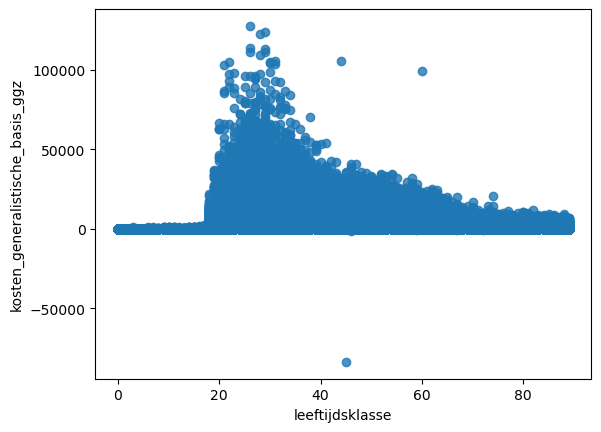

In [27]:
sns.regplot(y='kosten_generalistische_basis_ggz', x='leeftijdsklasse', data=df, fit_reg=True)